In [1]:
import pandas
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
def get_filename(path, contains, does_not_contain=[]):
    cmd = 'ls ' + path
    ls = os.popen(cmd).read()
    all_filelist = ls.split('\n')
    try:
        all_filelist.remove('')
    except:
        pass
    filelist = []
    for i, filename in enumerate(all_filelist):
        if contains in filename:
            fileok = True
            for nc in does_not_contain:
                if nc in filename:
                    fileok = False
            if fileok:
                return os.path.join(path, filename)

In [4]:
def get_flies_in_odor_and_speed(data, n):
    
    dataq = data.query('encounter == ' + str(n))
    
    tidxodor = np.where( (dataq.t.values[0] > 0)*(dataq.t.values[0] < 600) )
    tidxbefore = np.where( (dataq.t.values[0] < 0) )
    
    
    #odor_decay_slope = scipy.stats.linregress(dataq.t.values[0][tidxodor], dataq.n_flies_odor.values[0][tidxodor]).slope * 60 # times 60 fps
    n_odor_mean = np.mean(dataq.n_flies_odor.values[0][tidxodor] )
    n_odor_mean_normalized =  np.mean(dataq.n_flies_odor.values[0][tidxodor] ) - np.mean(dataq.n_flies_odor.values[0][tidxbefore] )
    n_odor_beginning = np.mean(dataq.n_flies_odor.values[0][tidxodor[0][0:120]] ) - np.mean(dataq.n_flies_odor.values[0][tidxbefore] )
    n_odor_end = np.mean(dataq.n_flies_odor.values[0][tidxodor[0][-120:]] ) - np.mean(dataq.n_flies_odor.values[0][tidxbefore] )
    
    odor_decay_slope = n_odor_end - n_odor_beginning
    
    t = dataq.localtime.values[0]
    
    speed = np.mean(dataq.speed.values[0][tidxbefore] ) 
    
    return n_odor_mean, n_odor_beginning, odor_decay_slope, speed, t, n_odor_mean_normalized

In [7]:
def build_dataframe():
    
    directories = [ '/media/caveman/CO2_HDF5/CO2_data_notrajecs/low_flow_walking_arena_A/multicat_ethanol_1sccm/',
                    '/media/caveman/CO2_HDF5/CO2_data_notrajecs/low_flow_walking_arena_A/multicat_ethanol_1sccm_24hrstarved/']
    #directories = [ '/media/caveman/CO2_HDF5/CO2_data_notrajecs/low_flow_walking_arena_A/multicat_ethanol_1sccm_24hrstarved/']
    #directories = [ '/media/caveman/CO2_HDF5/CO2_data_notrajecs/low_flow_walking_arena_A/multicat_ethanol_1sccm/']
    
    df = None
    
    for directory in directories:
        if '24hr' in directory:
            days = [1,2,3,4,5,6]
        else:
            days = [1,2,3,4]
        
        for day in days:
            if '24hr' in directory:
                group = day + 5
            else:
                group = day
            data_directory = os.path.join(directory, 'day'+str(day))
            data_fname = get_filename(data_directory, 'pd_data.pickle')
            data = pandas.read_pickle(data_fname)
            
            data = data.sort_values('localtime')
            data['encounter'] = np.argsort(data.localtime)

            for n in data.encounter.unique():
                n_odor_mean, n_odor_beginning, odor_decay_slope, speed, t, n_odor_mean_normalized  = get_flies_in_odor_and_speed(data, n)
                dfnew = pandas.DataFrame({ 'n': [n],
                                           'group': [group],
                                           'speed': [speed],
                                           'n_odor_beginning': [n_odor_beginning],
                                           'odor_decay_slope': [odor_decay_slope],
                                           'n_odor_mean': [n_odor_mean],
                                           'localtime': [np.abs(t-24)], 
                                           'n_odor_mean_normalized': [n_odor_mean_normalized]})
                if df is None:
                    df = dfnew
                else:
                    df = pandas.concat((df, dfnew), ignore_index=True)
        df = df.dropna()

    return df

In [12]:
try:
    df = pandas.read_hdf('CO2_paper_dataframe.hdf', 'CO2_paper_dataframe')
except:
    print('Building dataframe from raw data')
    df = build_dataframe()
    df.to_hdf('CO2_paper_dataframe.hdf', 'CO2_paper_dataframe')

In [13]:
query = 'n < 18'
df = df.query(query)

LinregressResult(slope=-0.008793608369435721, intercept=2.3316012956818217, rvalue=-0.03027218533235046, pvalue=0.6866488612199293, stderr=0.021762774359471437)

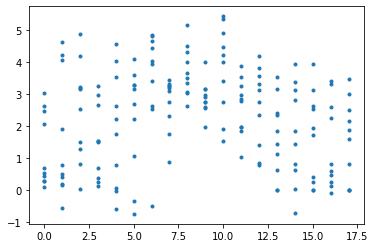

In [14]:
# at first there appears to be a positive correlation
plt.plot(df.n, df.n_odor_mean_normalized, '.')
scipy.stats.linregress(df.n, df.n_odor_mean_normalized)

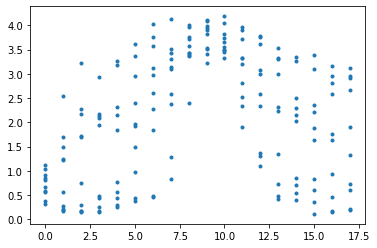

In [15]:
# but it is largely explained by the speed of the flies
plt.plot(df.n, df.speed, '.')

In [16]:
md = smf.mixedlm("n_odor_mean_normalized ~ speed*n", df, groups=df["group"])
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: n_odor_mean_normalized
No. Observations: 180     Method:             REML                  
No. Groups:       10      Scale:              0.9077                
Min. group size:  18      Log-Likelihood:     -256.9081             
Max. group size:  18      Converged:          Yes                   
Mean group size:  18.0                                              
-----------------------------------------------------------------------
              Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-----------------------------------------------------------------------
Intercept      0.553       0.228     2.425    0.015     0.106     0.999
speed          1.106       0.126     8.784    0.000     0.859     1.353
n             -0.026       0.024    -1.110    0.267    -0.073     0.020
speed:n       -0.022       0.013    -1.695    0.090    -0.048     0.003
Group Var      0.025       0.

In [17]:
md = smf.ols("n_odor_mean_normalized ~ speed*n", df)
mdf = md.fit()
print(mdf.summary())

                              OLS Regression Results                              
Dep. Variable:     n_odor_mean_normalized   R-squared:                       0.600
Model:                                OLS   Adj. R-squared:                  0.593
Method:                     Least Squares   F-statistic:                     87.92
Date:                    Tue, 25 May 2021   Prob (F-statistic):           8.28e-35
Time:                            11:12:15   Log-Likelihood:                -246.82
No. Observations:                     180   AIC:                             501.6
Df Residuals:                         176   BIC:                             514.4
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [18]:
md = smf.ols("n_odor_mean_normalized ~ speed", df)
mdf = md.fit()
print(mdf.summary())

                              OLS Regression Results                              
Dep. Variable:     n_odor_mean_normalized   R-squared:                       0.554
Model:                                OLS   Adj. R-squared:                  0.552
Method:                     Least Squares   F-statistic:                     221.3
Date:                    Tue, 25 May 2021   Prob (F-statistic):           4.72e-33
Time:                            11:12:19   Log-Likelihood:                -256.53
No. Observations:                     180   AIC:                             517.1
Df Residuals:                         178   BIC:                             523.4
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [19]:
table = sm.stats.anova_lm(mdf, typ=3)

In [20]:
print(table)

               sum_sq     df           F        PR(>F)
Intercept    8.102482    1.0    7.913661  5.457757e-03
speed      226.580755    1.0  221.300505  4.721193e-33
Residual   182.247096  178.0         NaN           NaN
